In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
import gensim
import torch

from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from math import comb
from itertools import combinations

from joblib import Parallel, delayed

import string
import os 

In [49]:
df = pd.read_csv('pivotRPAS.csv', header=[0,1,2])

In [50]:
df.columns

MultiIndex([('Unnamed: 0_level_0',              'Phase',     'CardResponseID'),
            ('Unnamed: 1_level_0', 'Unnamed: 1_level_1',                 'ID'),
            ('Unnamed: 2_level_0', 'Unnamed: 2_level_1',               'Card'),
            ('Unnamed: 3_level_0', 'Unnamed: 3_level_1',          'Response#'),
            (          'Response',                  'C', 'Unnamed: 4_level_2'),
            (          'Response',                  'R', 'Unnamed: 5_level_2')],
           )

In [51]:
df.columns = ['CardResponseID', 'ID', 'Card', 'Response#', 'ResponseC', 'ResponseR']

In [52]:
df

,CardResponseID,ID,Card,Response#,ResponseC,ResponseR
0,1000-1,1000,1,1,"On this one, this is a butterfly. What, do you...","Butterfly that is how it is shaped. Ink, blob..."
1,1000-2,1000,2,2,And I said apes too right? Yeah. Color on top....,Blood apes. That is what it looks like.
2,1000-3,1000,3,3,"There, there. How it is shaped.",Let’s see. Two kangaroos.
3,1000-4,1000,3,4,In the middle. How the shape. It has got the w...,Butterfly.
4,1000-5,1000,3,5,"Right there. How it is colored, how it looks l...",And a splash of blood.
...,...,...,...,...,...,...
2048,1112-11,1112,6,11,This was the cocoon here. It’s coming out. Its...,"This looks like - Ah, these are some tough one..."
2049,1112-12,1112,7,12,"Head, body and they are facing each other. The...",2 girls looking at each other they’ve got pony...
2050,1112-13,1112,8,13,They have a lion and a lion on the side of the...,"Something on a Budweiser cans, a design. I am ..."
2051,1112-14,1112,9,14,It just looks like to me. I don’t know. Buttoc...,I don't see anything. It’s nothing. I don’t se...


# Check word counts

In [53]:
ResponseCwordcount = (df['ResponseC'].apply(lambda x: len(x.split())))

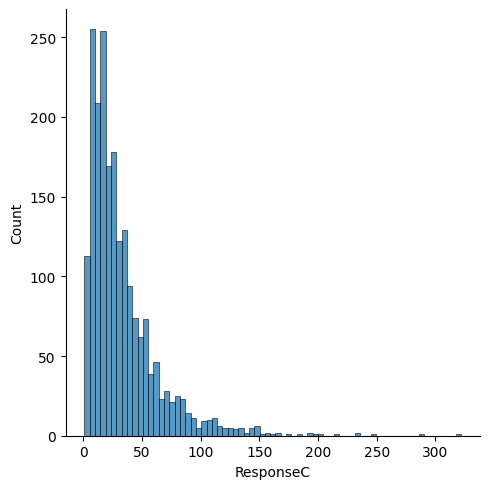

In [54]:
sns.displot(ResponseCwordcount, kde=False)

In [55]:
ResponseRwordcount = (df['ResponseR'].apply(lambda x: len(x.split())))

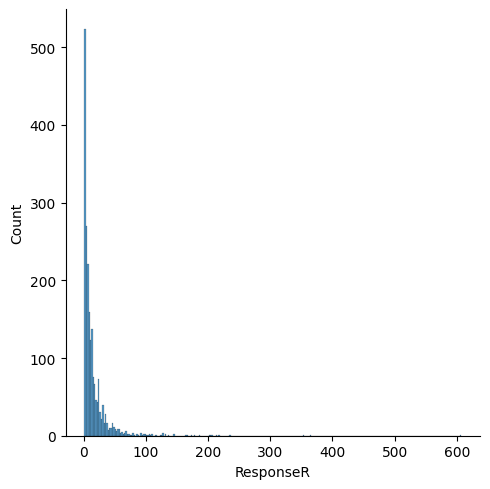

In [56]:
sns.displot(ResponseRwordcount, kde=False)

In [57]:
ResponseCwordcount.sort_values()

1440      1
1878      1
1501      1
1508      1
296       2
       ... 
1465    234
1473    234
1668    248
1407    290
1280    322
Name: ResponseC, Length: 2053, dtype: int64

In [58]:
ResponseRwordcount.sort_values()

1930      1
296       1
1438      1
1526      1
540       1
       ... 
1285    218
53      234
1258    353
1280    364
1276    607
Name: ResponseR, Length: 2053, dtype: int64

In [59]:
df['wordcountC'] = ResponseCwordcount

In [60]:
df['wordcountR'] = ResponseRwordcount

In [61]:
df[df['wordcountR']==607]['ResponseR'].values

array(["On or off the clock is a rattlesnake with its fangs, and toes right here. And they both are connected with the color change right here and here. Can’t see the bottom of the mouth and it’s just being swallowed here, as the deterioration from the rattlesnake and the top of his nose is right there. Yeah these open spots are just where he’s moving his teeth into his mouth and you’re able to make the picture with the toads. One end, I’m thinking it’s right here. Wherever those are. One, two, three, four, fangs. And then there’s the fangs that got both feet. The venom has taken effect to the body of the turtle, not turtle, toad. Not a free agent but it’s got a goofy shade around the eyeball and it’s got poison around here. It has a scary rattlesnake, has four inches. Well, right there is the size of the rattlesnakes jowls. They don’t go too far into the left of the snake pit. It’s hooked onto here, which is the bunk, which means it probably went back and forth with the ponds. Leaves 

# Inter-response cosine similarity

# Roberta

In [62]:
model = SentenceTransformer('all-roberta-large-v1')

In [64]:
model.max_seq_length = 512

In [65]:
robertaCosSim = df.apply(lambda x: util.cos_sim(model.encode(x.ResponseR), model.encode(x.ResponseC)), axis=1)

In [66]:
robertaCosSimNumpy = robertaCosSim.apply(lambda x:x[0].numpy()[0])

In [67]:
df['robertaCosSim'] = robertaCosSimNumpy

In [68]:
robertaCosSimNumpy

0       0.508829
1       0.518750
2       0.140403
3       0.417869
4       0.363010
          ...   
2048    0.542886
2049    0.656538
2050    0.332090
2051    0.552664
2052    0.488668
Length: 2053, dtype: float32

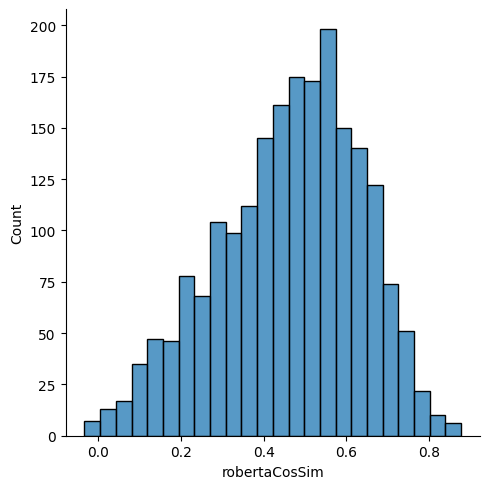

In [126]:
sns.displot(df['robertaCosSim'])

# Glove

In [70]:
model = SentenceTransformer('average_word_embeddings_glove.840B.300d')

In [71]:
model.max_seq_length

1000000

In [72]:
gloveCosSim = df.apply(lambda x: util.cos_sim(model.encode(x.ResponseR), model.encode(x.ResponseC)), axis=1)

In [73]:
gloveCosSimNumpy = gloveCosSim.apply(lambda x:x[0].numpy()[0])

In [74]:
df['gloveCosSim'] = gloveCosSimNumpy

In [75]:
df

,CardResponseID,ID,Card,Response#,ResponseC,ResponseR,wordcountC,wordcountR,robertaCosSim,gloveCosSim
0,1000-1,1000,1,1,"On this one, this is a butterfly. What, do you...","Butterfly that is how it is shaped. Ink, blob...",14,36,0.508829,0.566857
1,1000-2,1000,2,2,And I said apes too right? Yeah. Color on top....,Blood apes. That is what it looks like.,30,8,0.518750,0.589291
2,1000-3,1000,3,3,"There, there. How it is shaped.",Let’s see. Two kangaroos.,6,4,0.140403,0.249517
3,1000-4,1000,3,4,In the middle. How the shape. It has got the w...,Butterfly.,11,1,0.417869,-0.046160
4,1000-5,1000,3,5,"Right there. How it is colored, how it looks l...",And a splash of blood.,15,5,0.363010,0.247732
...,...,...,...,...,...,...,...,...,...,...
2048,1112-11,1112,6,11,This was the cocoon here. It’s coming out. Its...,"This looks like - Ah, these are some tough one...",19,25,0.542886,0.661646
2049,1112-12,1112,7,12,"Head, body and they are facing each other. The...",2 girls looking at each other they’ve got pony...,41,26,0.656538,0.754256
2050,1112-13,1112,8,13,They have a lion and a lion on the side of the...,"Something on a Budweiser cans, a design. I am ...",33,32,0.332090,0.669006
2051,1112-14,1112,9,14,It just looks like to me. I don’t know. Buttoc...,I don't see anything. It’s nothing. I don’t se...,26,39,0.552664,0.757185


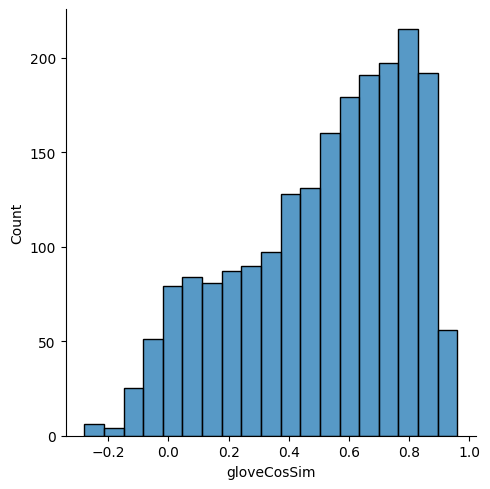

In [125]:
sns.displot(df['gloveCosSim'])

# Word embeddings

In [78]:
combinedResponse = df.apply(lambda x: x['ResponseC'] + " " + x['ResponseR'], axis = 1)

In [80]:
df['CombinedResponse'] = combinedResponse

In [81]:
df

,CardResponseID,ID,Card,Response#,ResponseC,ResponseR,wordcountC,wordcountR,robertaCosSim,gloveCosSim,CombinedResponse
0,1000-1,1000,1,1,"On this one, this is a butterfly. What, do you...","Butterfly that is how it is shaped. Ink, blob...",14,36,0.508829,0.566857,"On this one, this is a butterfly. What, do you..."
1,1000-2,1000,2,2,And I said apes too right? Yeah. Color on top....,Blood apes. That is what it looks like.,30,8,0.518750,0.589291,And I said apes too right? Yeah. Color on top....
2,1000-3,1000,3,3,"There, there. How it is shaped.",Let’s see. Two kangaroos.,6,4,0.140403,0.249517,"There, there. How it is shaped. Let’s see. Two..."
3,1000-4,1000,3,4,In the middle. How the shape. It has got the w...,Butterfly.,11,1,0.417869,-0.046160,In the middle. How the shape. It has got the w...
4,1000-5,1000,3,5,"Right there. How it is colored, how it looks l...",And a splash of blood.,15,5,0.363010,0.247732,"Right there. How it is colored, how it looks l..."
...,...,...,...,...,...,...,...,...,...,...,...
2048,1112-11,1112,6,11,This was the cocoon here. It’s coming out. Its...,"This looks like - Ah, these are some tough one...",19,25,0.542886,0.661646,This was the cocoon here. It’s coming out. Its...
2049,1112-12,1112,7,12,"Head, body and they are facing each other. The...",2 girls looking at each other they’ve got pony...,41,26,0.656538,0.754256,"Head, body and they are facing each other. The..."
2050,1112-13,1112,8,13,They have a lion and a lion on the side of the...,"Something on a Budweiser cans, a design. I am ...",33,32,0.332090,0.669006,They have a lion and a lion on the side of the...
2051,1112-14,1112,9,14,It just looks like to me. I don’t know. Buttoc...,I don't see anything. It’s nothing. I don’t se...,26,39,0.552664,0.757185,It just looks like to me. I don’t know. Buttoc...


### Glove

In [87]:
def totalPairwiseIncoherence(text):
    tensorOutput = model.encode(text, output_value='token_embeddings')
    # move from GPU to CPU and then turn to numpy array
    numpyOutput = tensorOutput.cpu().numpy()
    # cosine_similarity produces every pairwise combination as a matrix; taking the upper diagnoal is faster than individually computing every pair in a for loop
    # since np.triu masks every unwanted value with a 0; this approach that removes 0s assumes that there is no cosine similarity comparison that is exactly equal to 0 
    array1dimOutput = np.reshape(np.triu(cosine_similarity(numpyOutput, dense_output=False), k=1), -1)
    pairwiseIncoherence = array1dimOutput[array1dimOutput != 0]
    
    # calculate number of combinations to confirm that dropping zeroes from the array did not remove any cosine similarity comparisons
    pairwiseComparisonCount = comb(numpyOutput.shape[0], 2)
    # check if number of pairwise comparisons is as expected
    if pairwiseIncoherence.shape[0] == pairwiseComparisonCount:
        return(np.mean(pairwiseIncoherence))
    else:
        return('error')

In [89]:
gloveWordPairwiseCosSim = df['CombinedResponse'].apply(totalPairwiseIncoherence)

In [93]:
'error' in gloveWordPairwiseCosSim

False

In [95]:
df['gloveWordPairwiseCosSimSBERT'] = gloveWordPairwiseCosSim

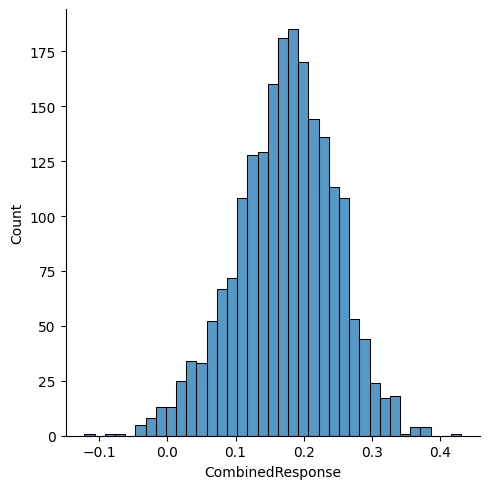

In [90]:
sns.displot(gloveWordPairwiseCosSim)

### Roberta

In [96]:
model = SentenceTransformer('all-roberta-large-v1')

In [97]:
model.max_seq_length = 512

In [98]:
robertaWordPairwiseCosSim = df['CombinedResponse'].apply(totalPairwiseIncoherence)

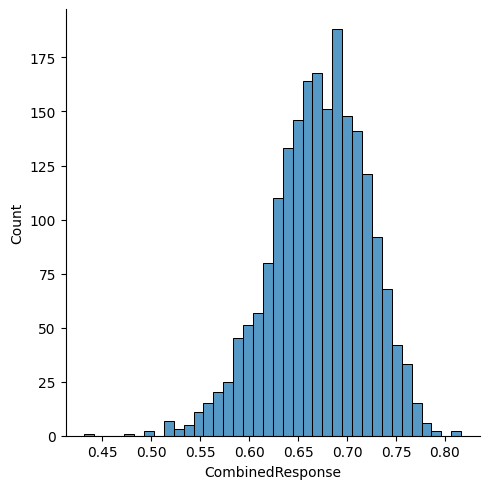

In [103]:
sns.displot(robertaWordPairwiseCosSim)

In [104]:
df['robertaWordPairwiseCosSim'] = robertaWordPairwiseCosSim

In [124]:
df.to_csv('cosSim.csv', index=False)

# Word2vec

In [3]:
def preprocess(text):
    newText = text.translate(
        str.maketrans('', '', string.punctuation)
    )
    newText = newText.lower()
    return(newText)

In [14]:
preprocessedText = df['CombinedResponse'].apply(preprocess)

In [16]:
df['preprocessedText'] = preprocessedText

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format('..\\..\\Google Drive\\GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
def word2vecPairwiseIncoherence(text):
    tokens = text.split(' ')
    vectorList = []
    for word in tokens:
        try:
            vectorList.append(model[word])
        except:
            errorWords.append(word)

    numpyOutput = np.array(vectorList)
    
    try:
        array1dimOutput = np.reshape(np.triu(cosine_similarity(numpyOutput, dense_output=False), k=1), -1)
        pairwiseIncoherence = array1dimOutput[array1dimOutput != 0]

        # calculate number of combinations to confirm that dropping zeroes from the array did not remove any cosine similarity comparisons
        pairwiseComparisonCount = comb(numpyOutput.shape[0], 2)
        # check if number of pairwise comparisons is as expected
        if pairwiseIncoherence.shape[0] == pairwiseComparisonCount:
            return(np.mean(pairwiseIncoherence))
        else:
            return('error')
    except:
        return(np.nan)

In [18]:
errorWords = []
word2vecWordPairwiseCosSim =  df['preprocessedText'].apply(word2vecPairwiseIncoherence)

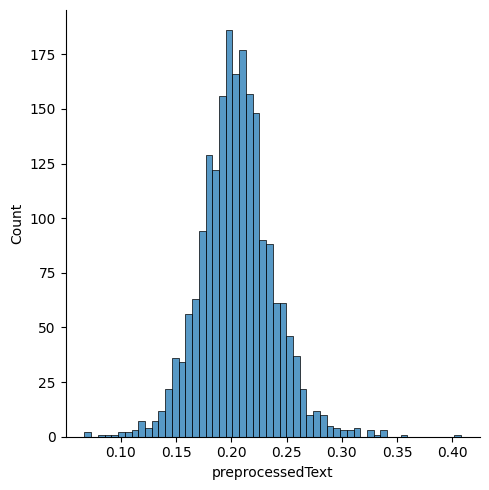

In [19]:
sns.displot(word2vecWordPairwiseCosSim)

In [20]:
df['word2vecWordPairwiseCosSim'] = word2vecWordPairwiseCosSim

# Glove (manual)

### 6B 300d

In [23]:
embeddingsDict = {}
problemVocab = []
with open('C:\\Users\\takee\\Google Drive\\glove.6B.300d.txt', 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], "float32")
            embeddingsDict[word] = vector
        except:
            problemVocab.append(word)

In [24]:
def glovePairwiseIncoherence(text):
    tokens = text.split(' ')
    vectorList = []
    for word in tokens:
        try:
        # will have to change this if changing to np.nan
            if embeddingsDict[word] == 'error':
                continue
            vectorList.append(embeddingsDict[word])
        except:
            errorWords.append(word)

    numpyOutput = np.array(vectorList)
    
    try:
        array1dimOutput = np.reshape(np.triu(cosine_similarity(numpyOutput, dense_output=False), k=1), -1)
        pairwiseIncoherence = array1dimOutput[array1dimOutput != 0]

        # calculate number of combinations to confirm that dropping zeroes from the array did not remove any cosine similarity comparisons
        pairwiseComparisonCount = comb(numpyOutput.shape[0], 2)
        # check if number of pairwise comparisons is as expected
        if pairwiseIncoherence.shape[0] == pairwiseComparisonCount:
            return(np.mean(pairwiseIncoherence))
        else:
            return('error')
    except:
        return(np.nan)

In [45]:
errorWords = []
gloveWordPairwiseCosSim =  df['preprocessedText'].apply(glovePairwiseIncoherence)

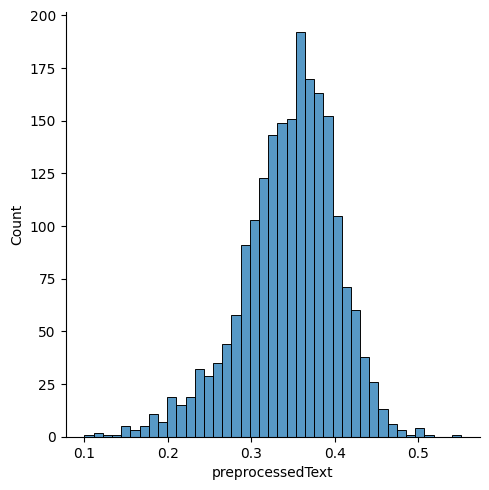

In [50]:
sns.displot(gloveWordPairwiseCosSim)

In [63]:
df['gloveWordPairwiseCosSim6b300d'] = gloveWordPairwiseCosSim

In [65]:
df.to_csv('cosSim.csv', index=False)

### 840b 300d

In [10]:
# for multicore processing 
def gloveConverter(line):
    values = line.split()
    word = values[0]
    tempDict = {}
    try:
        vector = np.asarray(values[1:], "float32")
        tempDict[word] = vector
        return(tempDict)
    except:
        # try rewrite this with np.nan? 
        tempDict[word] = 'error'
        return(tempDict)

In [6]:
with open('C:\\Users\\takee\\Google Drive\\glove.840B.300d.txt', 'r', encoding="utf-8") as f:
    # n_jobs = 4 worked
    parallel = Parallel(n_jobs=8)(delayed(gloveConverter)(line) for line in f)

In [7]:
embeddingsDict = {k: v for x in parallel for k, v in x.items()}

In [25]:
errorWords = []
gloveWordPairwiseCosSim840b300d =  df['preprocessedText'].apply(glovePairwiseIncoherence)

C:\Users\takee\AppData\Local\Temp\ipykernel_60196\2286975348.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if embeddingsDict[word] == 'error':
C:\Users\takee\AppData\Local\Temp\ipykernel_60196\2286975348.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if embeddingsDict[word] == 'error':
C:\Users\takee\AppData\Local\Temp\ipykernel_60196\2286975348.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if embeddingsDict[word] == 'error':
C:\Users\takee\AppData\Local\Temp\ipykernel_60196\2286975348.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if embeddingsDict[word] == 'error':
C:\Users\takee\AppData\Local\Temp\ipykernel_60196\2286975348.py:6: FutureWar

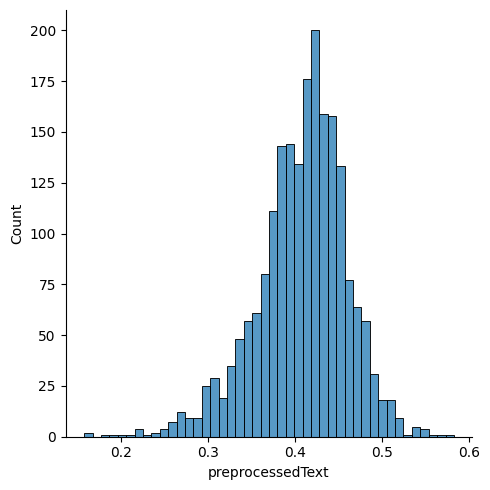

In [26]:
sns.displot(gloveWordPairwiseCosSim840b300d)

In [29]:
df['gloveWordPairwiseCosSim840b300d'] = gloveWordPairwiseCosSim840b300d

# BERT from Transformers

### Bert base

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def transformersPairwiseIncoherence(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        tensor_output = model(**encoded_input)
    
    # creating list of every unique pairwise combination of the embeddings (accessed at [0][0] index)
    # skip the first and last tokens of BERT output since these are the CLS and SEP tokens
    pairs = list(combinations(tensor_output[0][0][1:-1],2))
    
    pairwiseIncoherence = []
    for pair in pairs:
        pairwiseIncoherence.append(util.cos_sim(pair[0], pair[1]).numpy())
        
    return(np.mean(pairwiseIncoherence))

In [12]:
bertBaseCased = df['CombinedResponse'].apply(transformersPairwiseIncoherence)

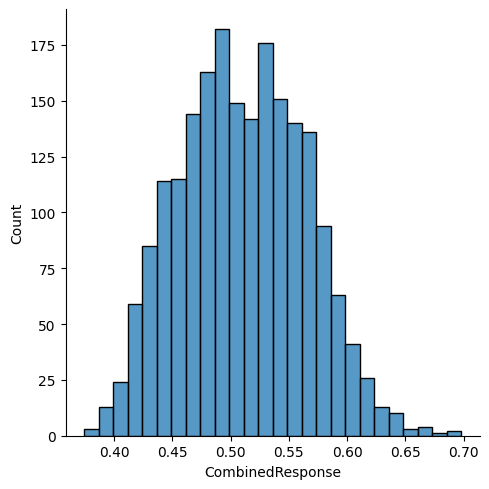

In [39]:
sns.displot(bertBaseCased)

In [16]:
df.columns[12]

'robertaWordPairwiseCosSim'

In [17]:
df.insert(13, 'bertBasePairwiseCosSim', bertBaseCased)

## Bert large

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained("bert-large-cased")

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
bertLargeCased = df['CombinedResponse'].apply(transformersPairwiseIncoherence)

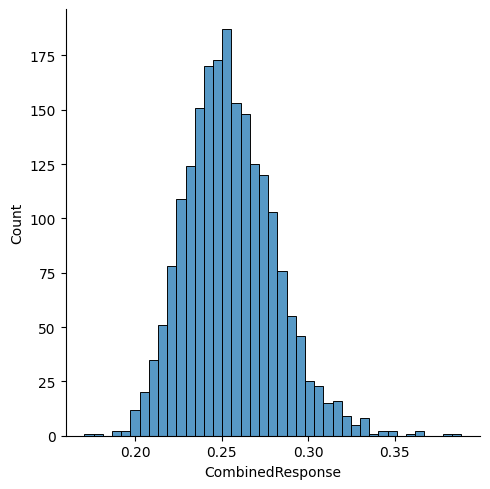

In [40]:
sns.displot(bertLargeCased)

In [27]:
df.insert(14, 'bertLargePairwiseCosSim', bertLargeCased)

In [28]:
df.to_csv('cosSim.csv', index=False)